### Step 0: Import libraries and split train/test data

In [1]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy

# Decision Trees
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Linear SVM
from sklearn.svm import LinearSVC
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# BernoulliNB
from sklearn.naive_bayes import BernoulliNB
# Quadratic Discriminant Analysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# Gaussian NB
from sklearn.naive_bayes import GaussianNB
# MLP as in Neural Network from SKLearn
from sklearn.neural_network import MLPClassifier
# Tensforflow for Neural Network ML
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
# Check if GPU is being recognized
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Visualizing libraries
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reading in the file for model training and testing
Steam_Reviews = pd.read_csv("Cleaned_Steam_Reviews.csv")

2024-06-03 23:25:02.343557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 23:25:04.861138: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-03 23:25:04.861302: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-03 23:25:04.861318: W tensorfl

Num GPUs Available:  1


A small subset of the original dataset has been taken for certain algorithms, because otherwise the kernel would die because of the lack of computational ressources and generally the algorithms being ressource intensive.

In [2]:
# Subset with 15k reviews for each genre

Steam_Reviews_Subset = pd.DataFrame()
for genre in Steam_Reviews["Genre"].unique():
    subset = Steam_Reviews[Steam_Reviews["Genre"] == genre].sample(n = 15000, random_state = 97) # sample command is great to create subsets
    Steam_Reviews_Subset = pd.concat([Steam_Reviews_Subset, subset])
    
# Steam_Reviews = Steam_Reviews_Subset

Step by Step Workflow:

1. Splitting the data into test and training data based on features (Reviews) and labels (Recommendation).
2. Vectorizing the data from text to numerical representations of aforementioned text
3. Initialize and train the model
4. Predict the results with the trained model
5. Evaluation based on performance metrics

In [2]:
# Split into test and train data: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, Y_train, Y_test = train_test_split(Steam_Reviews["Review"], Steam_Reviews["Genre"], test_size = 0.2, random_state = 27)

# Convert a collection of text documents (Steam Reviews in this case) to a matrix of token counts: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 
vector = TfidfVectorizer()
# Transformation happens with the same vectorizer instance, hence why first the fit_transform command is used and then only transform. This is done to prevent a dimensionalitiy mismatch error.
X_train_vector = vector.fit_transform(X_train)
X_test_vector = vector.transform(X_test)

# Arrays to be used for certain ML Algorithms
X_test_array = X_test_vector.toarray()
X_train_array = X_train_vector.toarray()

In [3]:
# This helps adjusting the weights accordingly
weights = Y_train.value_counts().to_dict()
weights

{'RPG': 102797,
 'Coop': 97776,
 'Strategy': 87518,
 'Platformer': 87139,
 'FPS': 86385,
 'Fighter': 74861}

The methods that were chosen from the sklearn package can be found here: https://scikit-learn.org/stable/modules/multiclass.html <br>

This code is responsible for the visualization

In [4]:
def visuals(cm, ML_type):
    plt.figure(figsize = (8,6))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = ["Coop","FPS", "Fighter","Platformer","RPG","Strategy"], yticklabels = ["Coop","FPS", "Fighter","Platformer","RPG","Strategy"])
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.title("Confusion Matrix for " + ML_type)

This code will be used to repeat the same cycle of fitting and evaluating for the different models of the sklearn package, since there is barely any difference in the actual coding part.

In [5]:
def MachineLearning(model, model_name, data_type = "sparse", weights = weights):
    if data_type == "sparse":
        model.fit(X_train_vector, Y_train)
    else:
        model.fit(X_train_array, Y_train)

    # Prediciting the values
    if data_type == "sparse":
        Y_prediction = model.predict(X_test_vector)
    else:
        Y_prediction = model.predict(X_test_array)

    # Evaluating the model
    acc = accuracy_score(Y_test, Y_prediction)
    print("Accuaracy Score: ", acc)

    # Checking the value counts for validity and potential overfitting
    test = pd.DataFrame({"Predicted Genre": Y_prediction})
    print(test["Predicted Genre"].value_counts())

    # Confusion Matrix
    cm_1 = confusion_matrix(Y_test, Y_prediction)

    # Visuals
    visuals(cm_1, model_name)
    return model

### 1. Decision Tree (Scikit-learn)

Source: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

Accuaracy Score:  0.7016626901282433
Predicted Genre
FPS           28833
RPG           27961
Coop          22961
Strategy      21463
Platformer    20185
Fighter       12717
Name: count, dtype: int64
CPU times: user 10min 6s, sys: 387 ms, total: 10min 7s
Wall time: 10min 7s


DecisionTreeClassifier(class_weight={'Coop': 97776, 'FPS': 86385,
                                     'Fighter': 74861, 'Platformer': 87139,
                                     'RPG': 102797, 'Strategy': 87518})

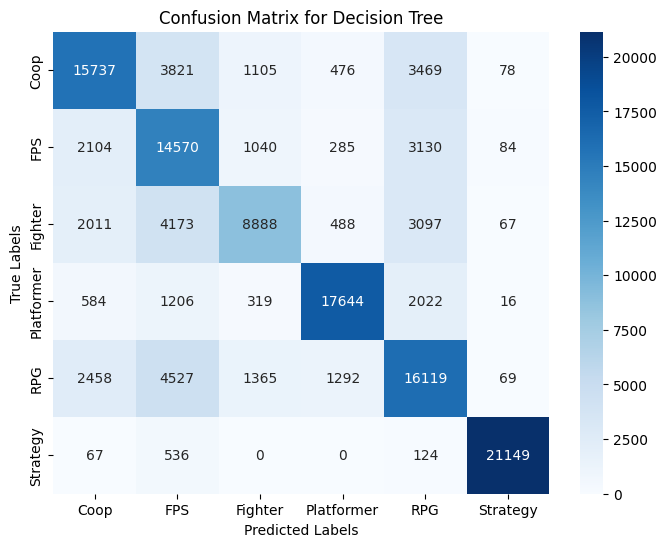

In [6]:
%%time
# Initialize the model and fitting it
DecisionTree = DecisionTreeClassifier(class_weight = weights)
MachineLearning(DecisionTree, "Decision Tree")

### 2. k-Neighbors Classifier (Scikit-learn)

Source: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

Accuaracy Score:  0.603802564867283
Predicted Genre
FPS           42774
Strategy      21302
Platformer    20340
Coop          18125
RPG           17486
Fighter       14093
Name: count, dtype: int64
CPU times: user 3h 51min 52s, sys: 2.91 s, total: 3h 51min 55s
Wall time: 20min 10s


KNeighborsClassifier(weights='distance')

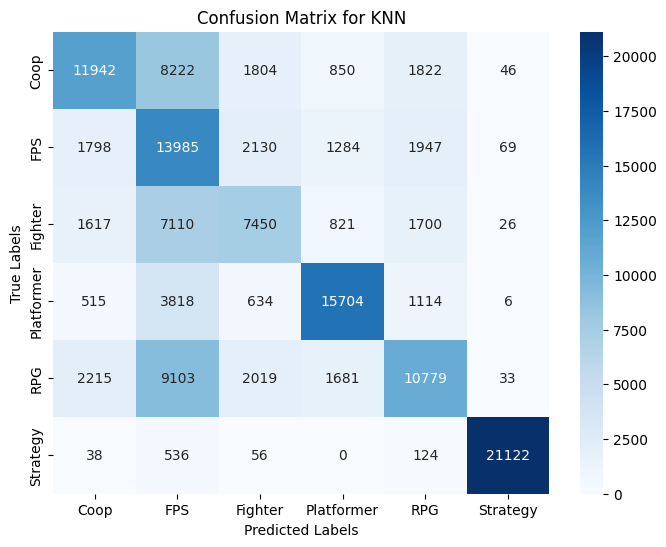

In [7]:
%%time
# Initialize the model
KNN = KNeighborsClassifier(n_neighbors = 5, weights = "distance")
MachineLearning(KNN, "KNN")

### 3. Logistic Regression (Scikit-learn)

Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

/usr/local/lib/python3.8/dist-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Accuaracy Score:  0.7332687145839547
Predicted Genre
RPG           30591
FPS           26401
Coop          23179
Strategy      22103
Platformer    19809
Fighter       12037
Name: count, dtype: int64
CPU times: user 1h 33min 56s, sys: 4h 43min 24s, total: 6h 17min 21s
Wall time: 37min 30s


LogisticRegression(class_weight={'Coop': 97776, 'FPS': 86385, 'Fighter': 74861,
                                 'Platformer': 87139, 'RPG': 102797,
                                 'Strategy': 87518},
                   multi_class='multinomial', random_state=27,
                   solver='newton-cg')

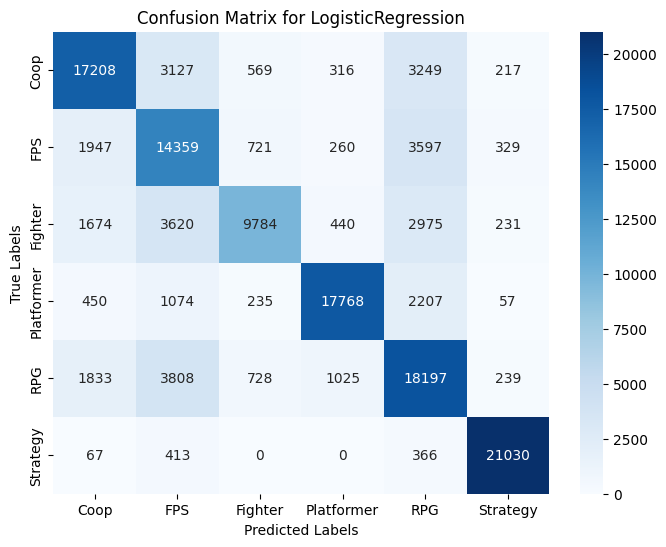

In [6]:
%%time
# Initialize the model
LogReg = LogisticRegression(class_weight = weights, random_state = 27, solver = "newton-cg", multi_class = "multinomial")
MachineLearning(LogReg, "LogisticRegression")

### 4. Random Forest (Scikit-learn)

Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

Accuaracy Score:  0.7432523113629586
Predicted Genre
RPG           29190
FPS           28744
Coop          23544
Strategy      21302
Platformer    19359
Fighter       11981
Name: count, dtype: int64
CPU times: user 1h 43min 10s, sys: 13.6 s, total: 1h 43min 23s
Wall time: 1h 43min 29s


RandomForestClassifier(class_weight={'Coop': 97776, 'FPS': 86385,
                                     'Fighter': 74861, 'Platformer': 87139,
                                     'RPG': 102797, 'Strategy': 87518},
                       random_state=27)

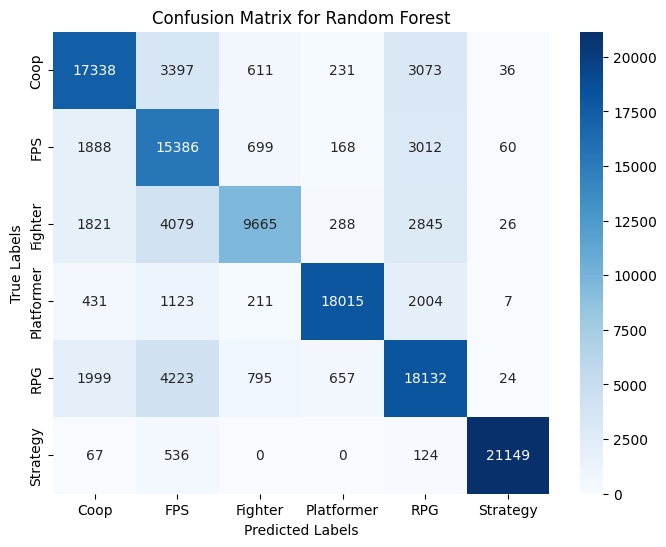

In [7]:
%%time
RF = RandomForestClassifier(random_state = 27, class_weight = weights)
MachineLearning(RF, "Random Forest")

### 5. Bernoulli Naive Bayes

Source:https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB

Accuaracy Score:  0.5498881598568446
Predicted Genre
FPS           65948
Coop          16360
RPG           16214
Strategy      12754
Platformer    12581
Fighter       10263
Name: count, dtype: int64
CPU times: user 3.07 s, sys: 1.38 s, total: 4.45 s
Wall time: 6.78 s


BernoulliNB()

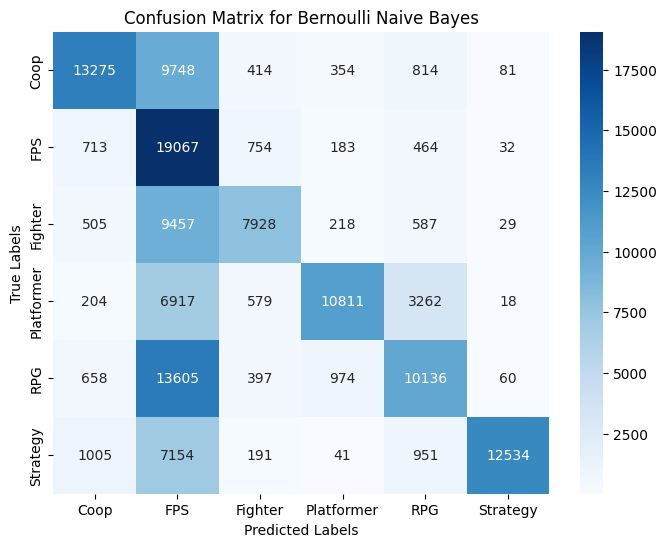

In [8]:
%%time
BNB = BernoulliNB()
MachineLearning(BNB, "Bernoulli Naive Bayes")

### 6. Quadratic Discriminant Analysis (Using Bayes Rules)

#### Subset used!

Source: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis

Sadly does not work with datasets as big as the one used for the other algorithms. This is why a subset is being used.

/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuaracy Score:  0.5233333333333333
Predicted Genre
Platformer    5395
Strategy      4596
FPS           3643
Coop          1836
Fighter       1479
RPG           1051
Name: count, dtype: int64
CPU times: user 4h 40min 16s, sys: 1h 31min 56s, total: 6h 12min 13s
Wall time: 32min 27s


QuadraticDiscriminantAnalysis()

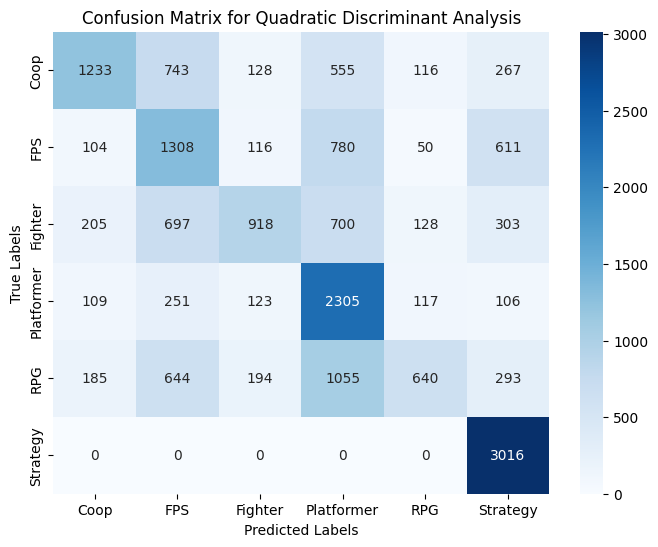

In [10]:
%%time
QDA = QuadraticDiscriminantAnalysis()
MachineLearning(QDA, "Quadratic Discriminant Analysis", data_type = "dense")

### 7. Gaussian Naive Bayes

#### Subset used!

Source: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB


Once again, this algorithm could not handle the dataset. This is why a subset is being used.

Accuaracy Score:  0.47883333333333333
Predicted Genre
Strategy      9079
Platformer    2791
FPS           2168
Coop          1705
Fighter       1319
RPG            938
Name: count, dtype: int64
CPU times: user 7 s, sys: 4.54 s, total: 11.5 s
Wall time: 11.5 s


GaussianNB()

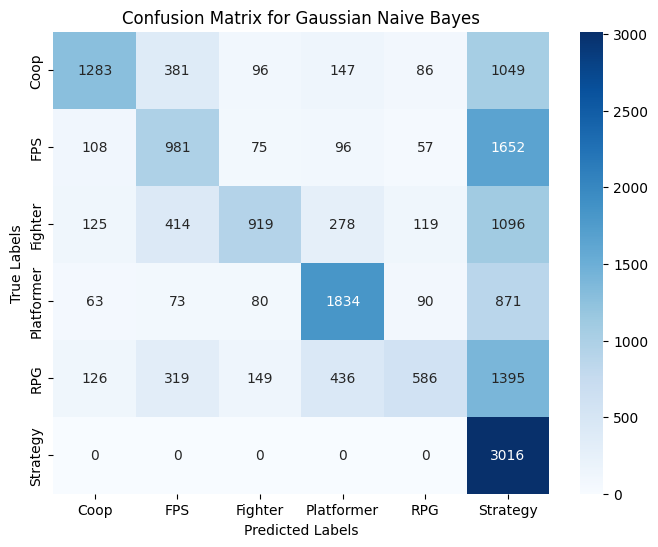

In [11]:
%%time
GNB = GaussianNB()
MachineLearning(GNB, "Gaussian Naive Bayes", data_type = "dense")

### 8. MLP Classifier (Scikit-learn)

Source: https://scikit-learn.org/MachineLearningmodules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuaracy Score:  0.7391813301521026
Predicted Genre
FPS           30881
RPG           25274
Coop          21500
Strategy      21345
Platformer    20375
Fighter       14745
Name: count, dtype: int64
CPU times: user 13h 16min 9s, sys: 1d 16h 19min 3s, total: 2d 5h 35min 12s
Wall time: 4h 37min 39s


MLPClassifier(random_state=27)

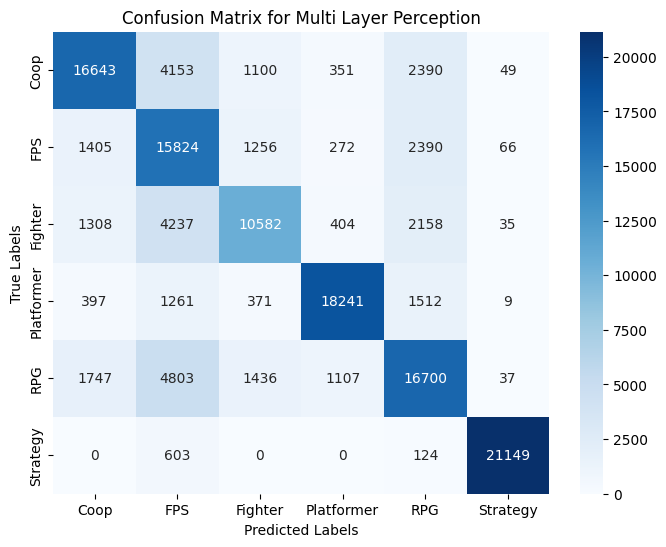

In [6]:
%%time
MLP = MLPClassifier(random_state = 27, hidden_layer_sizes = (100,))
MachineLearning(MLP, "Multi Layer Perceptron")

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuaracy Score:  0.7359155979719654
Predicted Genre
FPS           29050
RPG           25622
Coop          22229
Strategy      22119
Platformer    20646
Fighter       14454
Name: count, dtype: int64
CPU times: user 14h 3min 15s, sys: 1d 17h 49min 50s, total: 2d 7h 53min 5s
Wall time: 4h 49min 25s


MLPClassifier(hidden_layer_sizes=(100, 50), random_state=27)

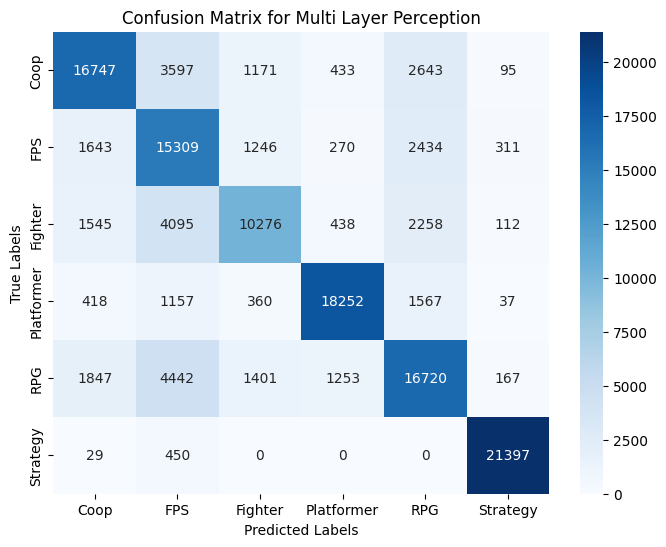

In [6]:
%%time
MLP = MLPClassifier(random_state = 27, hidden_layer_sizes = (100,50))
MachineLearning(MLP, "Multi Layer Perceptron")

### 9. Tensorflow and Recurrent Neural Networks

Source: https://www.tensorflow.org/tutorials/keras/text_classification <br>
Source: https://www.tensorflow.org/text/tutorials/text_classification_rnn <br>
Source: https://www.tensorflow.org/guide/keras/understanding_masking_and_padding <br>
Source: https://www.tensorflow.org/guide/keras/working_with_rnns <br>

Most of the knowledge from the Sentiment Analysis will be used here once again. Any difference in code will be highlighted in the markdown cells prior to the relevant code cells.

Changes:

- The Genre Labels need to be converted to integers for the RNN to function

In [6]:
# Seperating the label and features columns 
label = Steam_Reviews.pop("Genre")
feature = Steam_Reviews["Review"]

# Encoding the Genre to integers by using sklearn package
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(label)

# Converting it to tensor objects for better performance and results
features = tf.convert_to_tensor(feature.values, dtype = tf.string)
labels = tf.convert_to_tensor(labels_encoded, dtype = tf.int32)

# Uniting the columns
dataset = tf.data.Dataset.from_tensor_slices((features, labels))

# Creating test and train datasets
train_size = int(0.8 * len(feature))  # 80% for training
test_size = len(feature) - train_size  # Remaining 20% for testing

# Shuffling
dataset = dataset.shuffle(buffer_size=len(feature))

# The actual train/test datasets
train_dataset = dataset.take(train_size)  
test_dataset = dataset.skip(train_size) 

# Preparing the datasets for modelling
Buffer_size = 5000
batch_size = 64

train_dataset = train_dataset.shuffle(Buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Check for the label classes
mapping = label_encoder.classes_

for idx, genre in enumerate(mapping):
    print("Position ", idx, " corresponds to ", genre)

2024-06-03 23:26:31.337417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 23:26:35.543245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22173 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:41:00.0, compute capability: 8.0


Position  0  corresponds to  Coop
Position  1  corresponds to  FPS
Position  2  corresponds to  Fighter
Position  3  corresponds to  Platformer
Position  4  corresponds to  RPG
Position  5  corresponds to  Strategy


In [7]:
# Initialize empty lists to store features and labels
all_test_features = []
all_test_labels = []

# Using a for loop to iterate over the dataset, extracting both features and labels to use for the prediction part
for features, labels in test_dataset:
    all_test_features.append(features)
    all_test_labels.append(labels)

# Concatenate all the extracted values into a tensorflow variable
test_features = tf.concat(all_test_features, axis=0)
test_labels = tf.concat(all_test_labels, axis=0)

In [8]:
# Defining the accuracy variable to evaulate the tensor models
accuracy = tf.keras.metrics.Accuracy()

In [9]:
# Taken from: https://www.tensorflow.org/text/tutorials/text_classification_rnn

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode = "int", output_sequence_length = 200)

# Memory usage always killed the kernel, which is why a smaller subset was decided to be implemented
# This basically "ignores" less frequent words in order to save memory, once again finding the golden middle is key here
subset_size = 1000
subset = train_dataset.take(subset_size)

# Training on the subset
encoder.adapt(subset.map(lambda text, label: text))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


A lot of different subset_sizes were tried, as well as LSTM and GRU layers. The reason behind that is that the training would always get stuck during an epoch. Both CNN and RNN did have such problems.

Notable Changes:

- Using softmax to give each class a probability as well as changing the output dimension to the amount of classes in the Review dataset
- Using Sparse Categorical Crossentropy as the loss function

In [10]:
# Initiliaze the model by defining the different layers
RNNModel = tf.keras.Sequential([encoder, 
                                tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=32, mask_zero = True), 
                                tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
                                tf.keras.layers.Dense(32, activation = "relu"),
                                tf.keras.layers.Dense(6, activation = "softmax")])                                              #softmax is used to give each class a probability
                               
RNNModel.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),  # These parameters were taken from https://www.tensorflow.org/text/tutorials/text_classification_rnn
               optimizer=tf.keras.optimizers.Adam(1e-4),
               metrics = ["accuracy"])

This code was added because tensorflow proved to be incredibly unstable when training for the multiclass purposes. Things that were tried to counteract it:

Modify batch_size, buffer_size, layer_sizes, downsizing vocabulary, explicitly stating the tensortypes, adapting learning rate

None helped and the code would get stuck at random. Thus the checkpoint system was introduced!

Sources: 
- https://www.tensorflow.org/guide/checkpoint
- https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [11]:
%%time
# Because it was unstable and always stopped randomly training by getting stuck, a checkpoint system shall be introduced

# Defining the path where the checkpoints will be saved to
directory_checkpoint = "./backup"

# If that directory does not exist, it will be created
if not os.path.exists(directory_checkpoint):
    os.makedirs(directory_checkpoint)
    
# Naming convention
prefix = os.path.join(directory_checkpoint, "checkpoint_{epoch}")

# Defining the resume point
resume_point = tf.keras.callbacks.ModelCheckpoint(filepath = prefix, save_weights_only = True, save_freq = "epoch")

# Getting the latest checkpoint from where it ought to be resumed
latest_checkpoint = tf.train.latest_checkpoint(directory_checkpoint)

# If the training gets stuck again, we load the checkpoint
if latest_checkpoint:
    RNNModel.load_weights(latest_checkpoint)
    epoch_number = int(latest_checkpoint.split('_')[-1]) + 1
else:
    epoch_number = 0
    
    
# This is where the actual model training happens
Trained_RNNModel = RNNModel.fit(train_dataset, 
                                    epochs = 10,  # Definition of which arrays are to be passed and how many epochs (or rounds) the training should include. Each epoch counts as an iteration over the entire dataset.
                                    validation_data = test_dataset, 
                                    validation_steps = 30,
                                    callbacks=[resume_point],
                                    initial_epoch = epoch_number)     

Epoch 9/10


2024-06-03 23:03:36.764742: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_41/output/_22'
2024-06-03 23:03:44.149319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2024-06-03 23:03:45.067744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-03 23:03:45.137850: I tensorflow/compiler/xla/servic

8383/8383 [==============================] - 320s 36ms/step - loss: 1.0579 - accuracy: 0.5990 - val_loss: 0.8144 - val_accuracy: 0.6859
Epoch 10/10
8383/8383 [==============================] - 208s 25ms/step - loss: 0.7851 - accuracy: 0.6874 - val_loss: 0.7356 - val_accuracy: 0.7099
CPU times: user 12min 17s, sys: 1min 15s, total: 13min 33s
Wall time: 8min 47s


In [12]:
# Predict the labels for the test dataset
Y_prediction = RNNModel.predict(test_features, batch_size=batch_size)
Y_prediction = numpy.argmax(Y_prediction, axis=1)

# Convert test_labels to a numpy array
Y_test_array = test_labels.numpy()

# Convert numerical labels to strings
Y_test_array = Y_test_array.astype(str)

# Convert Y_prediction to strings
Y_prediction = Y_prediction.astype(str)

# Generate the confusion matrix
cm = confusion_matrix(Y_test_array, Y_prediction)

print(cm)

2096/2096 [==============================] - 24s 10ms/step
[[15673  4993   714   250  2825   140]
 [ 2238 15304   805   275  2623   251]
 [ 1873  5710  8545   291  2293    81]
 [  505  1452   297 17365  2038    22]
 [ 2303  6425   929  1073 15020   138]
 [   55   711     0     0     0 20903]]


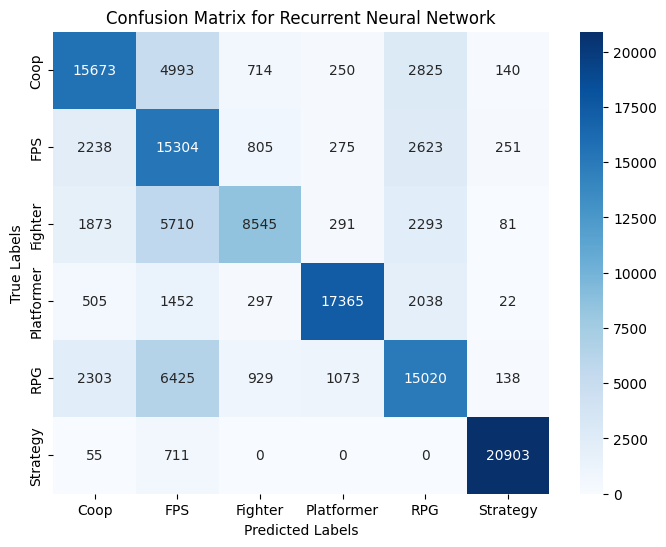

In [13]:
# Visuals
visuals(cm, "Recurrent Neural Network")

In [14]:
print("Test loss: ", Trained_RNNModel.history["loss"][1])
print("Test acc: ", Trained_RNNModel.history["accuracy"][1])

Test loss:  0.7850823402404785
Test acc:  0.6874231100082397


In [15]:
loss, accuracy = RNNModel.evaluate(test_features, test_labels)
print("Accuracy:", accuracy)

4192/4192 [==============================] - 38s 9ms/step - loss: 0.7686 - accuracy: 0.6920
Accuracy: 0.6919698715209961


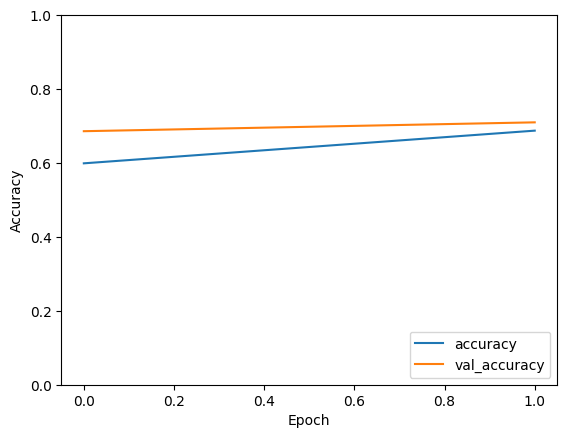

In [16]:
# Line Graph
# Taken from https://www.tensorflow.org/tutorials/images/cnn

plt.plot(Trained_RNNModel.history['accuracy'], label='accuracy')
plt.plot(Trained_RNNModel.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

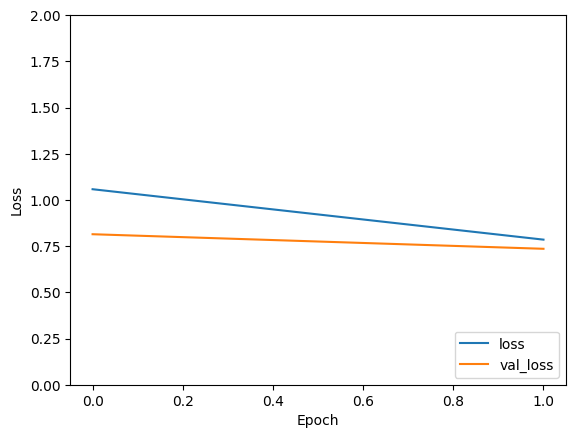

In [17]:
plt.plot(Trained_RNNModel.history['loss'], label = 'loss')
plt.plot(Trained_RNNModel.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')

### 10. Tensorflow and Convolutional Neural Networks

Source: https://www.tensorflow.org/tutorials/images/cnn

Changes:

- Once again the output layer will edited to the amount of classes being present in the dataset, as well as another activation function to accomodate this change.
- Using Sparse Categorical Cross Entropy

In [10]:
# Initiliaze the model by defining the different layers
CNNModel = tf.keras.Sequential([encoder,
                               tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero = True), 
                               tf.keras.layers.Conv1D(64, 5, activation = "relu"),         # A one dimensional (No images, only text, thus 1 dimension) convolutional layer. 64 describes the number of kernels in the layer. Each kernel learns to detect patterns. Imagine it like 64 children learning patterns.
                               tf.keras.layers.GlobalMaxPooling1D(),                       # The 5 from the line above describes how many adjacent tokens are being considered in the pattern recognition at the same time. Pooling describes reduction of dimensionality while reatining the most important features-
                               tf.keras.layers.Dense(32, activation = "relu"),
                               tf.keras.layers.Dense(6, activation = "softmax")])
                               
CNNModel.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),  # These parameters were taken from https://www.tensorflow.org/text/tutorials/text_classification_rnn (Can also be used for CNN, since BinaryCrossentropy is used for binary labels (in this case, recommended or not recommended)
               optimizer = "adam",
               metrics = ["accuracy"])

In [11]:
%%time
# Because it was unstable and always stopped randomly training by getting stuck, a checkpoint system shall be introduced

# Defining the path where the checkpoints will be saved to
directory_checkpoint = "./backup"

# If that directory does not exist, it will be created
if not os.path.exists(directory_checkpoint):
    os.makedirs(directory_checkpoint)
    
# Naming convention
prefix = os.path.join(directory_checkpoint, "checkpoint_cnn_{epoch}")

# Defining the resume point
resume_point = tf.keras.callbacks.ModelCheckpoint(filepath = prefix, save_weights_only = True, save_freq = "epoch")

# Getting the latest checkpoint from where it ought to be resumed
latest_checkpoint = tf.train.latest_checkpoint(directory_checkpoint)

# If the training gets stuck again, we load the checkpoint
if latest_checkpoint:
    CNNModel.load_weights(latest_checkpoint)
    epoch_number = int(latest_checkpoint.split('_')[-1]) + 1
else:
    epoch_number = 0

# This is where the actual model training happens
Trained_CNNModel = CNNModel.fit(train_dataset, epochs = 10,       # Definition of which arrays are to be passed and how many epochs (or rounds) the training should include. Each epoch counts as an iteration over the entire dataset.
                           validation_data = test_dataset,       # The validation_data requires not only labels, but also validation data. This is because after each epoch, the validation data is used to evalute the model in its current state.                           
                           validation_steps = 30,                # Additionally in the source, there is also a command called validation steps. This specifies how many batches we want to use from our entire dataset.
                            callbacks=[resume_point],
                            initial_epoch = epoch_number)                

Epoch 8/10


2024-06-03 23:26:59.934739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2024-06-03 23:27:05.514563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-03 23:27:05.631491: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f525c021760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-03 23:27:05.632925: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A30, Compute Capability 8.0
2024-06-03 23:27:05.919356: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-03 23:27:06.840566: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8383/8383 [==============================] - 156s 16ms/step - loss: 0.8269 - accuracy: 0.6658 - val_loss: 0.7384 - val_accuracy: 0.6974
Epoch 9/10
8383/8383 [==============================] - 51s 6ms/step - loss: 0.7328 - accuracy: 0.7051 - val_loss: 0.7317 - val_accuracy: 0.6974
Epoch 10/10
8383/8383 [==============================] - 51s 6ms/step - loss: 0.7170 - accuracy: 0.7113 - val_loss: 0.7214 - val_accuracy: 0.7026
CPU times: user 4min 38s, sys: 33.9 s, total: 5min 12s
Wall time: 4min 17s


In [12]:
# Predict the labels for the test dataset
Y_prediction = CNNModel.predict(test_features, batch_size=batch_size)
Y_prediction = numpy.argmax(Y_prediction, axis=1)

# Convert test_labels to a numpy array
Y_test_array = test_labels.numpy()

# Convert numerical labels to strings
Y_test_array = Y_test_array.astype(str)

# Convert Y_prediction to strings
Y_prediction = Y_prediction.astype(str)

# Generate the confusion matrix
cm = confusion_matrix(Y_test_array, Y_prediction)

print(cm)

2096/2096 [==============================] - 7s 3ms/step
[[15106  5594   625   144  2993    78]
 [  974 16974   587    86  2536   167]
 [  954  6408  8783   181  2482   100]
 [  238  1640   189 17559  2154    27]
 [ 1177  6708   636   542 16354   129]
 [    0   837     0     0     0 21158]]


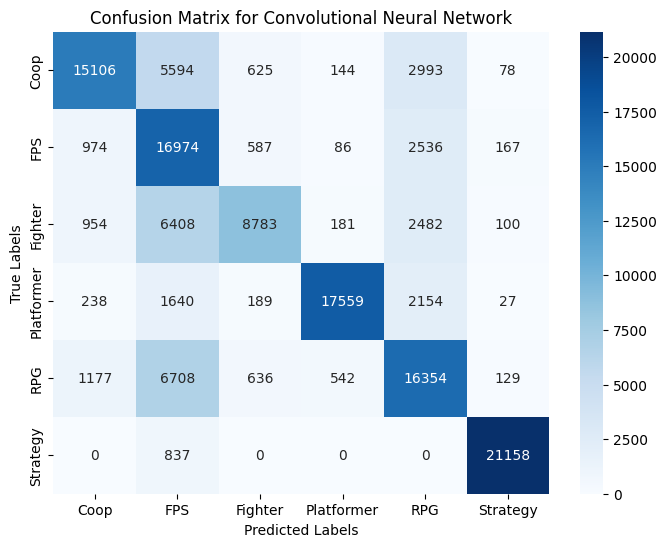

In [13]:
# Visuals
visuals(cm, "Convolutional Neural Network")

In [14]:
print("Test loss: ", Trained_CNNModel.history["loss"][2])
print("Test acc: ", Trained_CNNModel.history["accuracy"][2])

Test loss:  0.7170483469963074
Test acc:  0.7113105058670044


In [15]:
loss, accuracy = CNNModel.evaluate(test_features, test_labels)
print("Accuracy:", accuracy)

4192/4192 [==============================] - 12s 3ms/step - loss: 0.7042 - accuracy: 0.7153
Accuracy: 0.7152848243713379


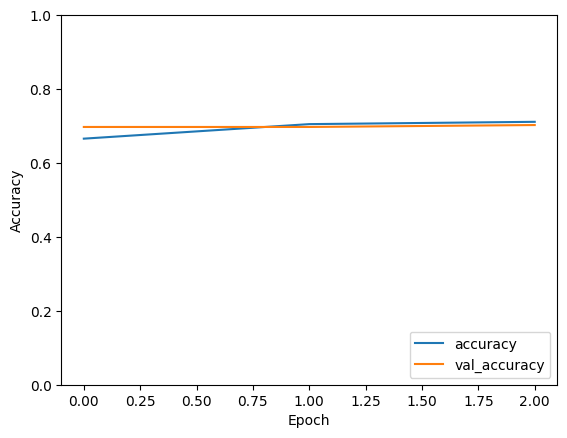

In [16]:
# Line Graph
# Taken from https://www.tensorflow.org/tutorials/images/cnn

plt.plot(Trained_CNNModel.history['accuracy'], label='accuracy')
plt.plot(Trained_CNNModel.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

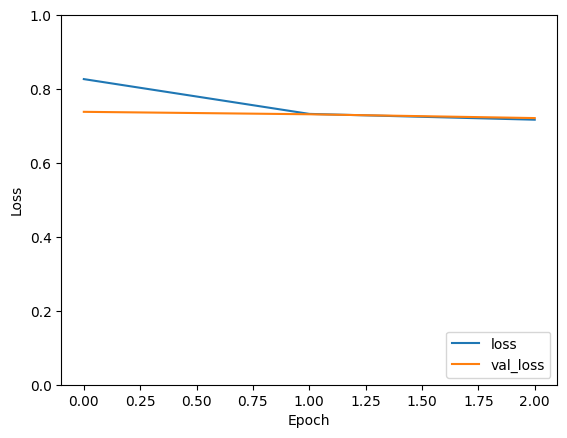

In [17]:
plt.plot(Trained_CNNModel.history['loss'], label = 'loss')
plt.plot(Trained_CNNModel.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')